### Random Forest

Random Forest는 **Ensemble Learning**의 일종.
(i.e. 여러 개의 약한 학습기를 결합하여 더 강한 학습기를 만드는 방법)

- **Bagging = Bootstarp Aggregating**
    - 여러 개의 모델을 독립적으로 학습한 후, 이들의 예측 결과를 결합하여 최종 예측을 도출하는 방식
        - Bootstrapping: 원본 dataset에서 중복을 허용하여 sampling, 각 sample data는 독립적으로 모델을 학습시킴
        - Aggregating: 각 모델의 예측은 분류 문제의 경우 다수결, 회귀 문제의 경우 평균으로 결합함
    - 각 모델이 독립적으로 학습되는 만큼, overfitting을 방지하는 데에 효과적
    - 대표적으로 Random Forest

- **Boosting**
    - 약한 학습기를 순차적으로 학습시키며, 이전 모델의 오류를 보완해 나가는 방식
        - 첫 번째 모델이 학습된 후, 잘못 예측한 data point에 더 높은 가중치를 주어 다음 모델을 학습시킴
    - overfitting의 위험이 있음
    - 대표적으로 AdaBoost, Gradient Boosting Machine GBM, XGBoost

- **Stacking**
    - 서로 다른 종류의 모델의 예측 결과를 meta-model로 입력하여 최종 예측을 도출하는 방식
        - meta-model: 각 모델이 예측한 값을 새로운 데이터로 사용하는 것


#### `voting Classifier` hyper-parameter

In [1]:
from sklearn.ensemble import VotingClassifier

**Classificaton**
- `estimators`
    - ensemble에 포함될 모델 목록을 지정
    - 이 목록은 (name, estimator) 쌍으로 구성된 리스트여야 함 (e.g. `[('decision_tree', dt), ('random_forest', rf)]`)
- `voting`
    - voting 유형을 지정
        - `hard`(default): 다수결
        - `soft`: 예측 확률을 평균을 활용
- `weights`
    - 각 예측기에 대한 가중치를 지정. 단, 가중치는 `voting='soft'`일 때만 적용됨
    - `None` (default), e.g. 첫번째 모델에 1, 두번째 모델에 2의 가중치를 부여하기 위해서는 `[1, 2]`
- `n_jobs`
    - ensemble을 병렬로 학습할 때 사용할 CPU core 수를 지정함
    - `None` (default), e.g. 사용 가능한 모든 core를 사용하도록 하고 싶다면 `-1`
- `flatten_transform`
    - 각 예측기의 `transform` 결과를 2D 배열로 변환할지 여부를 지정함. 단, `voting='soft'`일 때만 적용됨
    - `True` (default), `False`
- `verbose`
    - ensemble 학습 과정의 진행 상황을 출력할지 여부를 지정함
    - `False` (default), `True`


In [2]:
from sklearn.ensemble import VotingRegressor

**Regression**
- `estimators`
    - ensemble에 포함될 모델 목록을 지정
    - 이 목록은 (name, estimator) 쌍으로 구성된 리스트여야 함 (e.g. `[('linear', lr), ('random_forest', rf)]`)
- `weights`
    - 각 예측기에 대한 가중치를 지정. 예측기의 예측 결과에 대한 가중 평균을 계산
    - `None` (default), e.g. 첫번째 모델에 1, 두번째 모델에 2의 가중치를 부여하기 위해서는 `[1, 2]`
- `n_jobs`
    - ensemble을 병렬로 학습할 때 사용할 CPU core 수를 지정함
    - `None` (default), e.g. 사용 가능한 모든 core를 사용하도록 하고 싶다면 `-1`
- `verbose`
    - ensemble 학습 과정의 진행 상황을 출력할지 여부를 지정함
    - `False` (default), `True`


#### Exercise with Titanic Dataset

In [39]:
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

from sklearn.ensemble import RandomForestClassifier
from sklearn.ensemble import VotingClassifier
from sklearn.tree import DecisionTreeClassifier

from sklearn.metrics import accuracy_score, classification_report, confusion_matrix
from sklearn.model_selection import train_test_split, cross_val_score

from sklearn.pipeline import Pipeline

from sklearn.preprocessing import StandardScaler, OneHotEncoder, PowerTransformer
from sklearn.compose import ColumnTransformer
from sklearn.impute import SimpleImputer
from sklearn.feature_selection import RFECV, VarianceThreshold

from bayes_opt import BayesianOptimization
from sklearn.model_selection import learning_curve

##### Load Dataset

In [15]:
titanic = sns.load_dataset('titanic')

In [16]:
titanic.head()

,survived,pclass,sex,age,sibsp,parch,fare,embarked,class,who,adult_male,deck,embark_town,alive,alone
0,0,3,male,22.0,1,0,7.2500,S,Third,man,True,NaN,Southampton,no,False
1,1,1,female,38.0,1,0,71.2833,C,First,woman,False,C,Cherbourg,yes,False
2,1,3,female,26.0,0,0,7.9250,S,Third,woman,False,NaN,Southampton,yes,True
3,1,1,female,35.0,1,0,53.1000,S,First,woman,False,C,Southampton,yes,False
4,0,3,male,35.0,0,0,8.0500,S,Third,man,True,NaN,Southampton,no,True


##### Handle Missing Values
e.g. replacing missing values in `Age` and `Embarked` with mean or mode

In [17]:
titanic['age'].fillna(titanic['age'].mean(), inplace=True)

C:\Users\ShinJiyoon\AppData\Local\Temp\ipykernel_28228\1944751947.py:1: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplace=True)', try using 'df.method({col: value}, inplace=True)' or df[col] = df[col].method(value) instead, to perform the operation inplace on the original object.


  titanic['age'].fillna(titanic['age'].mean(), inplace=True)


In [19]:
titanic['embarked'].fillna(titanic['embarked'].mode()[0], inplace=True)
titanic['embark_town'].fillna(titanic['embark_town'].mode()[0], inplace=True)
titanic['fare'].fillna(titanic['fare'].mean(), inplace=True)

C:\Users\ShinJiyoon\AppData\Local\Temp\ipykernel_28228\1151983026.py:3: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplace=True)', try using 'df.method({col: value}, inplace=True)' or df[col] = df[col].method(value) instead, to perform the operation inplace on the original object.


  titanic['fare'].fillna(titanic['fare'].mean(), inplace=True)


##### Encoding Categorical Variable

In [20]:
titanic = pd.get_dummies(titanic, 
                         columns=['sex', 'embarked', 'class', 'who', 'embark_town',
                                  'deck', 'alone'],
                         drop_first=True)

##### Remove Unnecessary Columns

In [21]:
titanic.drop(['alive', 'adult_male', 'parch', 'sibsp'], axis=1, inplace=True)

##### define X and y

In [22]:
X = titanic.drop('survived', axis=1)
y = titanic['survived']

##### Split Dataset

In [23]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=1)

##### Train Random Forest Model

In [24]:
rf = RandomForestClassifier(n_estimators=100, random_state=1)
rf.fit(X_train, y_train)

RandomForestClassifier(random_state=1)

##### Predict Using the Model

In [25]:
y_pred = rf.predict(X_test)

In [26]:
accuracy = accuracy_score(y_test, y_pred)
print(f'acc: {accuracy:.4f}')
print(classification_report(y_test, y_pred))
print(confusion_matrix(y_test, y_pred))

acc: 0.7542
              precision    recall  f1-score   support

           0       0.76      0.86      0.81       106
           1       0.75      0.60      0.67        73

    accuracy                           0.75       179
   macro avg       0.75      0.73      0.74       179
weighted avg       0.75      0.75      0.75       179

[[91 15]
 [29 44]]


- Cross-Validation Accuracy: 0.7542
    - 모델이 교차 검증을 통해 얻은 정확도. 즉, 모델이 올바르게 예측한 데이터의 비율이 75.42%임을 의미함
- Precision, Recall, F1-Score, Support
    - Precision: 모델이 해당 클래스라고 예측한 것들 중 실제로 맞는 비율
        - 클래스 0에 대한 precision은 0.76, 클래스 1에 대한 precision은 0.75
    - Recall: 실제 해당 클래스인 것들 중에서 모델이 올바르게 예측한 비율
        - 클래스 0에 대한 recall은 0.86, 클래스 1에 대한 recall은 0.60
    - F1-Score: Precision과 Recall의 조화 평균
        - F1-Score가 높을수록 precision과 recall 사이의 균형을 잘 유지하고 있음을 의미함
    - Support: 각 클래스의 실제 sample 수
- Accuracy: 전체 예측 중 올바르게 예측된 비율
- Macro Accuracy: 각 클래스의 지표의 단순 평균
- Weighted Average: 각 클래스의 support에 가중치를 두고 계산한 평균
- confusion matrix
    - True Negative: 실제로 0인 샘플 중 91개를 0으로 정확히 예측
    - False Positive: 실제로 0인 샘플 중 15개를 1로 잘못 예측
    - False Negative: 실제로 1인 샘플 중 29개를 0으로 잘못 예측
    - True Positive: 실제로 1인 샘플 중 44개를 1로 정확히 예측

- 모델의 전반적인 성능은 꽤 좋지만, 클래스 1에 대한 recall(0.60)이 낮아, 클래스 1의 데이터를 올바르게 예측하는 데에 어려움을 겪고 있는 것으로 보임

##### Display Feature Importance

In [28]:
f_im = rf.feature_importances_

for i, feature in enumerate(X.columns):
    print(f'{feature}: {f_im[i]:.4f}')

pclass: 0.0543
age: 0.2300
fare: 0.2368
sex_male: 0.1132
embarked_Q: 0.0057
embarked_S: 0.0123
class_Second: 0.0086
class_Third: 0.0458
who_man: 0.1259
who_woman: 0.0745
embark_town_Queenstown: 0.0063
embark_town_Southampton: 0.0132
deck_B: 0.0098
deck_C: 0.0082
deck_D: 0.0113
deck_E: 0.0123
deck_F: 0.0032
deck_G: 0.0021
alone_True: 0.0265


##### Explore OOB and Tune Hyper-parameter with Bayesian Optimization

In [29]:
# 성능 평가 함수
def rf_eval(n_estimators, max_depth, min_samples_split, min_samples_leaf):
    clf = RandomForestClassifier(
        n_estimators=int(n_estimators),
        max_depth=int(max_depth),
        min_samples_split=int(min_samples_split),
        min_samples_leaf=int(min_samples_leaf),
        oob_score=True,
        random_state=1
    )
    
    return cross_val_score(clf, X_train, y_train, scoring='accuracy', cv=3).mean()

In [31]:
# 베이지안 최적화
optimizer = BayesianOptimization(
    f=rf_eval,
    pbounds={
        'n_estimators':(100,400),
        'max_depth':(10,20),
        'min_samples_split':(2,10),
        'min_samples_leaf':(1,20)
    },
    random_state=1
)

optimizer.maximize(
    n_iter=20,
    init_points=5
)

print('best parameters: ', optimizer.max['params'])
print('best accuracy: ', optimizer.max['target'])

|   iter    |  target   | max_depth | min_sa... | min_sa... | n_esti... |
-------------------------------------------------------------------------
| 1         | 0.8287    | 14.17     | 14.69     | 2.001     | 190.7     |
| 2         | 0.8287    | 11.47     | 2.754     | 3.49      | 203.7     |
| 3         | 0.8273    | 13.97     | 11.24     | 5.354     | 305.6     |
| 4         | 0.816     | 12.04     | 17.68     | 2.219     | 301.1     |
| 5         | 0.8287    | 14.17     | 11.62     | 3.123     | 159.4     |
| 6         | 0.8287    | 13.3      | 11.72     | 3.073     | 159.2     |
| 7         | 0.8287    | 12.73     | 11.58     | 6.101     | 199.7     |
| 8         | 0.8273    | 18.51     | 4.515     | 2.553     | 194.0     |
| 9         | 0.8315    | 15.81     | 4.547     | 9.442     | 310.9     |
| 10        | 0.8371    | 20.0      | 1.0       | 10.0      | 303.5     |
| 11        | 0.8371    | 20.0      | 1.0       | 10.0      | 295.3     |
| 12        | 0.8357    | 20.0      | 

- `BayesianOptimization`
    - `f`: 최적화할 목표 함수, 주어진 hyper-parameter 조합에 대해 random forest 모델의 성능을 평가하고 그 결과를 반환함
    - `pbounds`: 최적화할 hyper-parameter의 범위를 정의함
        - `n_estimators`: 트리의 개수, 100에서 400 사이
        - `max_depth`: 트리의 최대 깊이, 10에서 20 사이
        - `min_samples_split`: 노드를 분할하기 위한 최소 샘플 수, 2에서 10 사이
        - `min_samples_leaf`: 리프 노드가 될 수 있는 최소 샘플 수, 1에서 20 사이

- `optimizer.maximize`
    - `n_iter`: 최적화 반복 횟수
    - `init_points`: 최적화 과정에서 5번의 초기 탐색은 무작위로 수행함. 이 초기 탐색을 통해 베이지안 최적화는 함수의 대략적인 형태를 이해하게 되고, 그 후에 최적의 hyper-parameter의 조합의 찾아 나가게 됨

##### Train Random Forest with Optimal Hyper-parameters and Calculate OOB Score

In [32]:
best_params = optimizer.max['params']

In [33]:
rf_best = RandomForestClassifier(
    n_estimators=int(best_params['n_estimators']),
    max_depth=int(best_params['max_depth']),
    min_samples_split=int(best_params['min_samples_split']),
    min_samples_leaf=int(best_params['min_samples_leaf']),
    oob_score=True,
    random_state=1
)

In [34]:
rf_best.fit(X_train, y_train)

RandomForestClassifier(max_depth=20, min_samples_split=10, n_estimators=303,
                       oob_score=True, random_state=1)

In [35]:
y_pred = rf_best.predict(X_test)

In [37]:
accuracy = accuracy_score(y_test, y_pred)
print(f'acc: {accuracy:.4f}')

acc: 0.7821


In [38]:
print(classification_report(y_test, y_pred))
print(confusion_matrix(y_test, y_pred))

              precision    recall  f1-score   support

           0       0.76      0.93      0.84       106
           1       0.85      0.56      0.68        73

    accuracy                           0.78       179
   macro avg       0.80      0.75      0.76       179
weighted avg       0.80      0.78      0.77       179

[[99  7]
 [32 41]]


##### Generate a Learning Curve with Optimal Hyper-parameters

In [47]:
train_sizes, train_scores, test_scores = learning_curve(
   RandomForestClassifier(
        n_estimators=int(best_params['n_estimators']),
        max_depth=int(best_params['max_depth']),
        min_samples_split=int(best_params['min_samples_split']),
        min_samples_leaf=int(best_params['min_samples_leaf']),
        oob_score=True,
        random_state=1
    ),
   X_train, y_train, cv=3, n_jobs=-1, train_sizes=np.linspace(0.1, 1.0, 5)
)

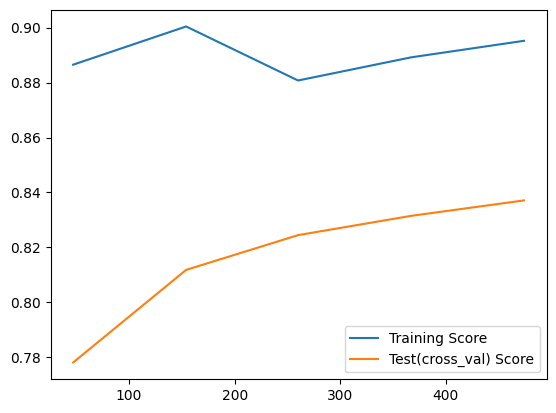

In [48]:
plt.plot(train_sizes, np.mean(train_scores, axis=1), label='Training Score')
plt.plot(train_sizes, np.mean(test_scores, axis=1), label='Test(cross_val) Score')
plt.legend()
plt.show()

- `learning_curve`: 
    - `train_sizes`는 학습 데이터 크기의 비율을 나타내며, 위에서는 10%에서 100%까지 5단계로 설정되어 있음
    - `cv=3`은 3-fold cross-validation을 의미함
- learning curve를 그릴 수 있는 데이터를 얻게 되며, 이를 통해 모델이 데이터에 대해 얼마나 잘 일반화되고 있는지 평가할 수 있음